## Imports

In [309]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.model_selection import GridSearchCV

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

## Pré-processamento

In [310]:
# obtendo dados
data = pd.read_csv('eleicoes_2006_a_2010.csv')
data_test = pd.read_csv('eleicoes_2014.csv')

data = pd.concat([data, data_test])

data = data.drop(columns=['sequencial_candidato', 'nome'])
# as colunas sequencial_candidato e nome foram removidas, dado que não agregam
# para a regressão, sendo informações individuais e que, intuitivamente, não possuem
# influência no resultado

In [311]:
data.head()

,ano,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,...,qtd_doadores,recursos de outros candidatos/comitês,recursos de pessoas físicas,recursos de pessoas jurídicas,recursos próprios,qtd_despesas,qtd_fornecedores,descricao_cargo,grau_instrucao,descricao_ocupacao
0,2006,AP,PT,6.0,6.0,16600.00,2766.666667,NaN,9000.0,6300.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,RO,PT,13.0,13.0,22826.00,1755.846154,6625.0,15000.0,1000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006,AP,PT,17.0,16.0,148120.80,9257.550000,2250.0,34150.0,62220.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006,MS,PRONA,6.0,6.0,3001.12,500.186667,NaN,1150.0,1101.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006,RO,PT,48.0,48.0,NaN,NaN,NaN,50878.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [312]:
# visualizando tipos das colunas (features)
data.dtypes

ano                                        int64
uf                                        object
partido                                   object
quantidade_doacoes                       float64
quantidade_doadores                      float64
total_receita                            float64
media_receita                            float64
recursos_de_outros_candidatos/comites    float64
recursos_de_pessoas_fisicas              float64
recursos_de_pessoas_juridicas            float64
recursos_proprios                        float64
quantidade_despesas                      float64
quantidade_fornecedores                  float64
total_despesa                            float64
media_despesa                            float64
cargo                                     object
sexo                                      object
grau                                      object
estado_civil                              object
ocupacao                                  object
votos               

Dentre todas as colunas numéricas, foram selecionadas todas, exceto a coluna ano, dado que a mesma também não deveria influenciar no resultado e será utilizada para particionar os dados, conforme orientado na descrição da atividade.

In [313]:
features_to_log = [
    "quantidade_doacoes",
    "quantidade_doadores",
    "total_receita",
    "media_receita",
    "recursos_de_outros_candidatos/comites",
    "recursos_de_pessoas_fisicas",
    "recursos_proprios",
    "quantidade_despesas",
    "quantidade_fornecedores",
    "total_despesa",
    "media_despesa",
    "votos" # variável alvo
]

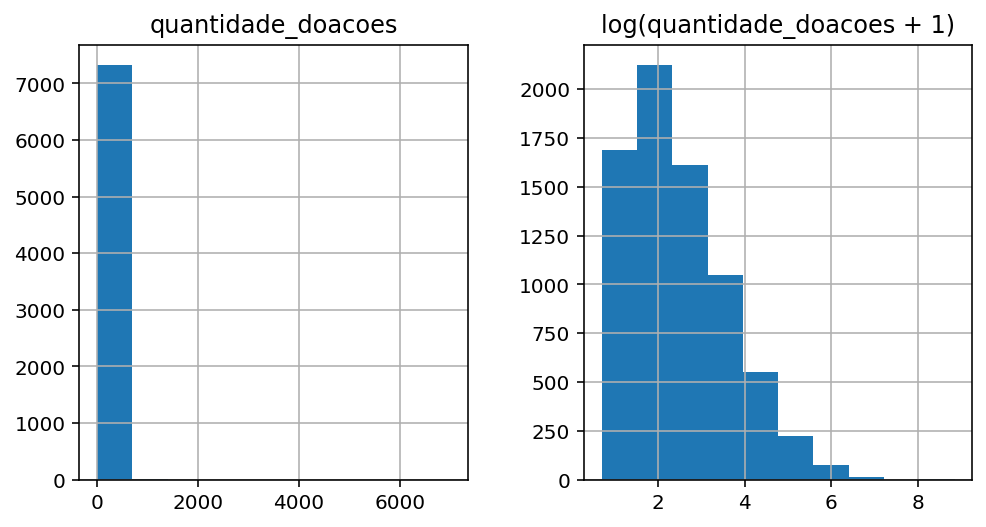

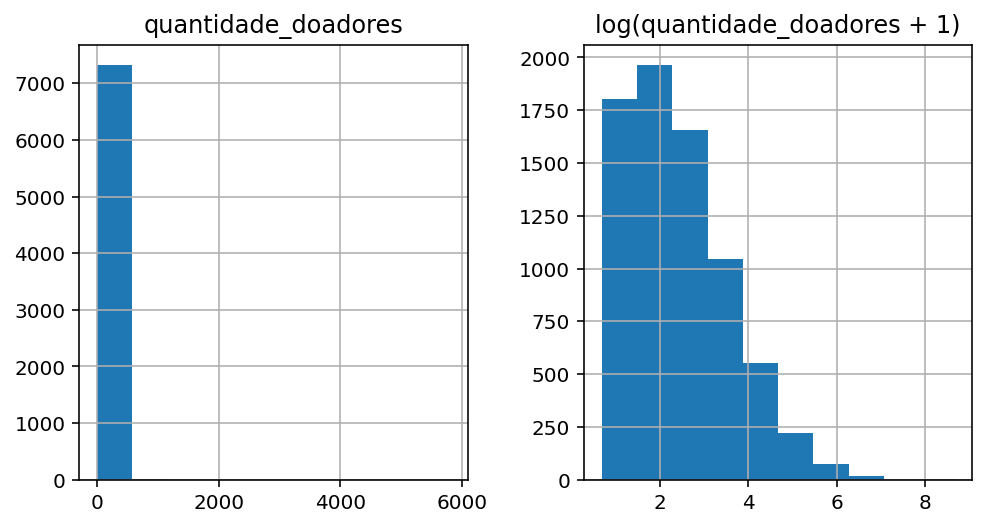

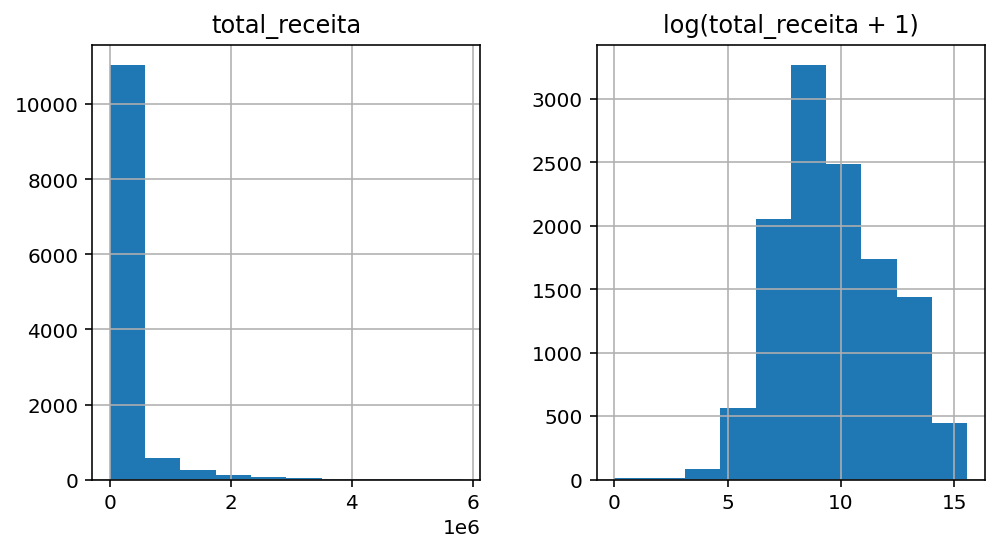

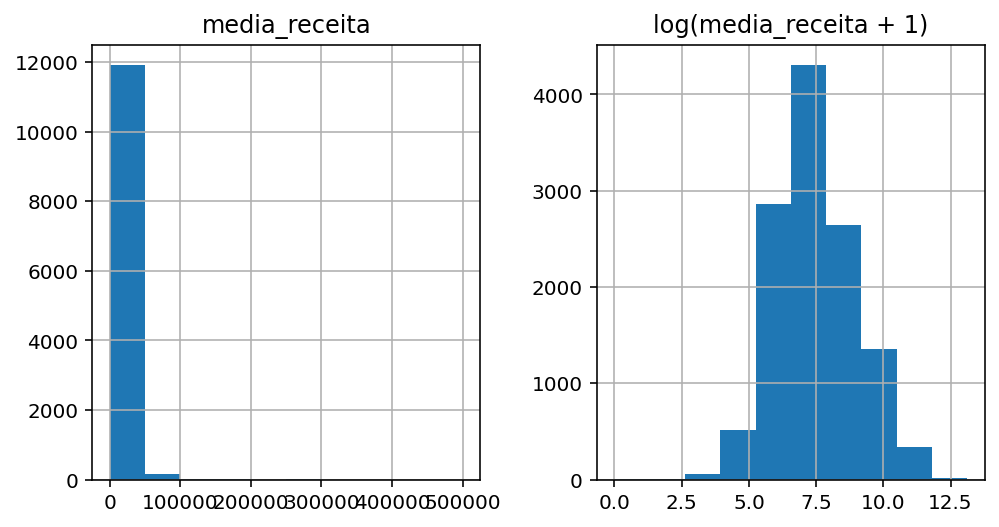

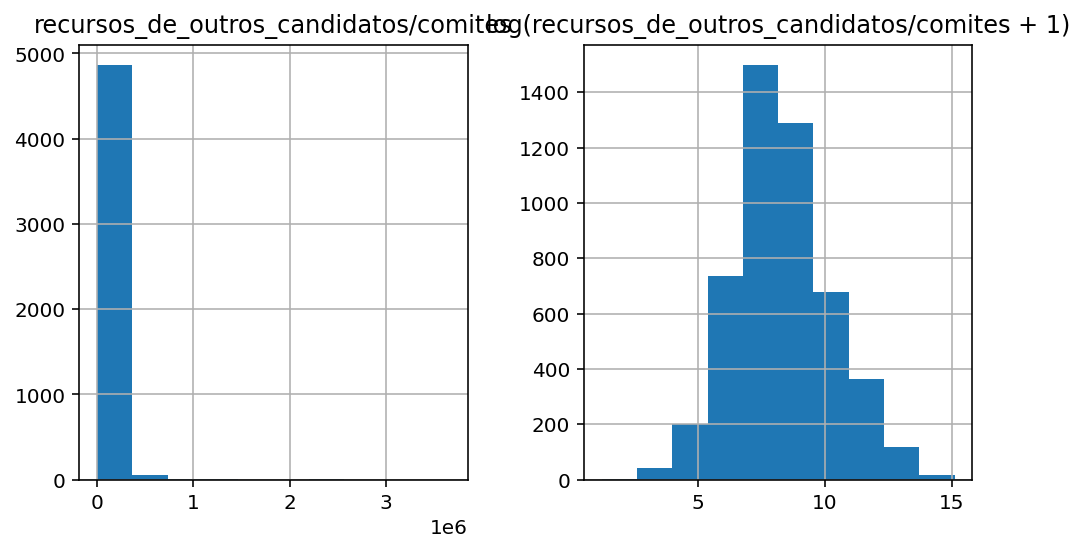

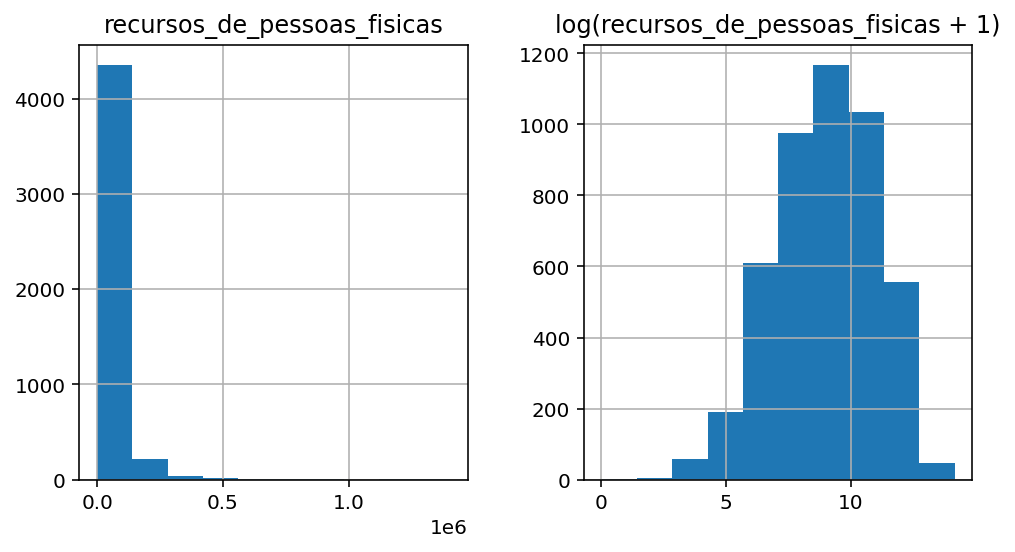

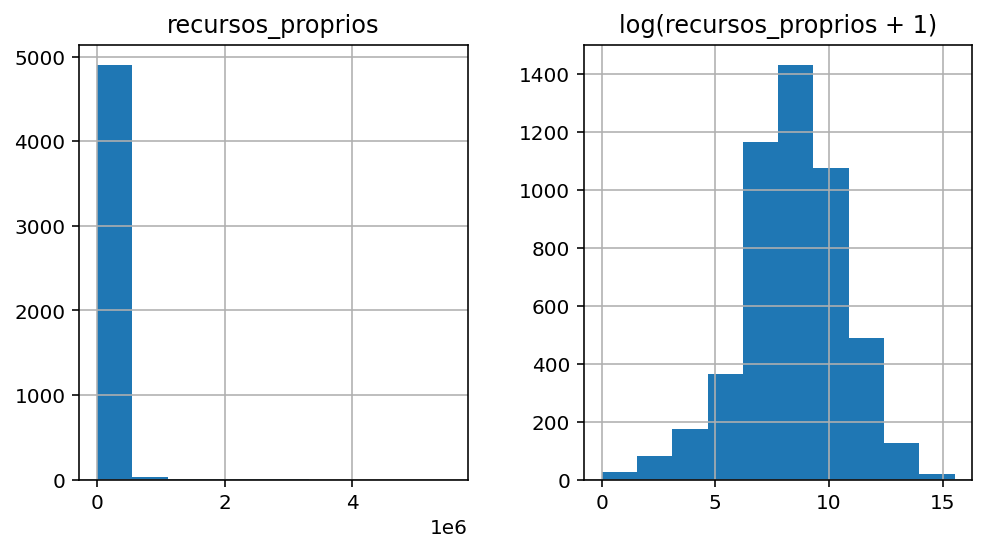

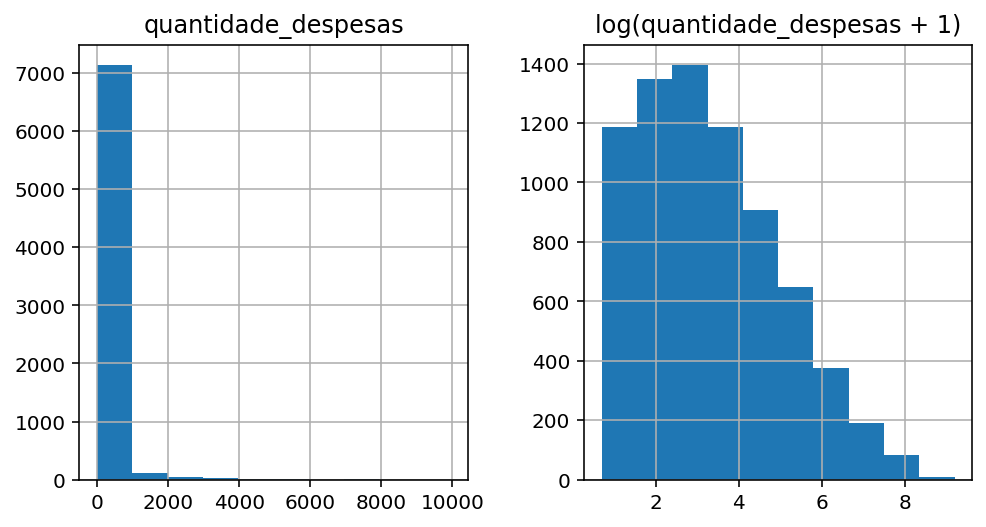

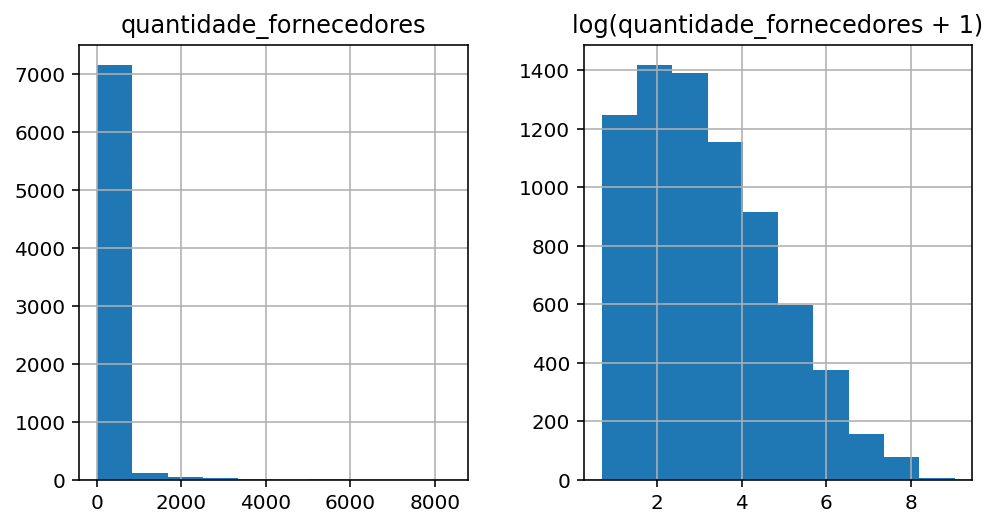

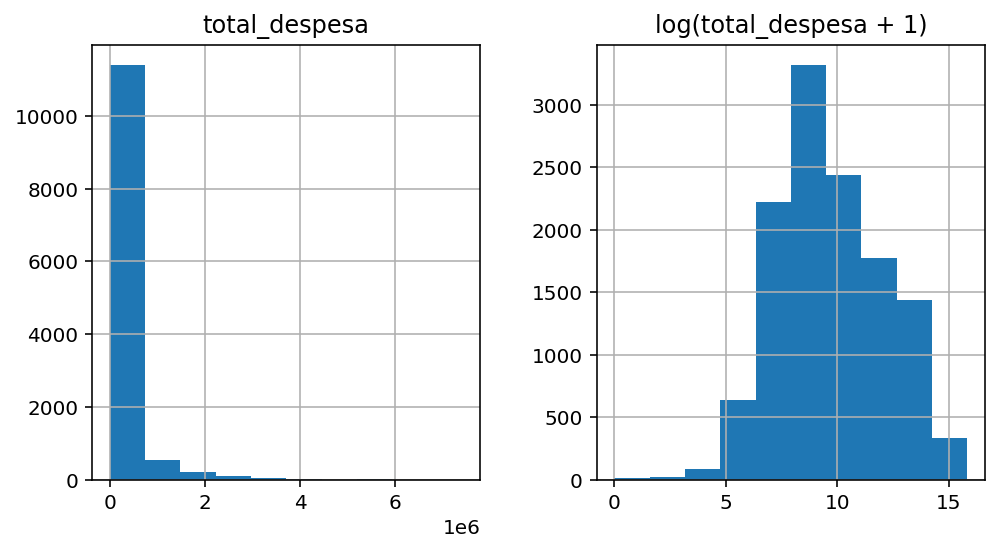

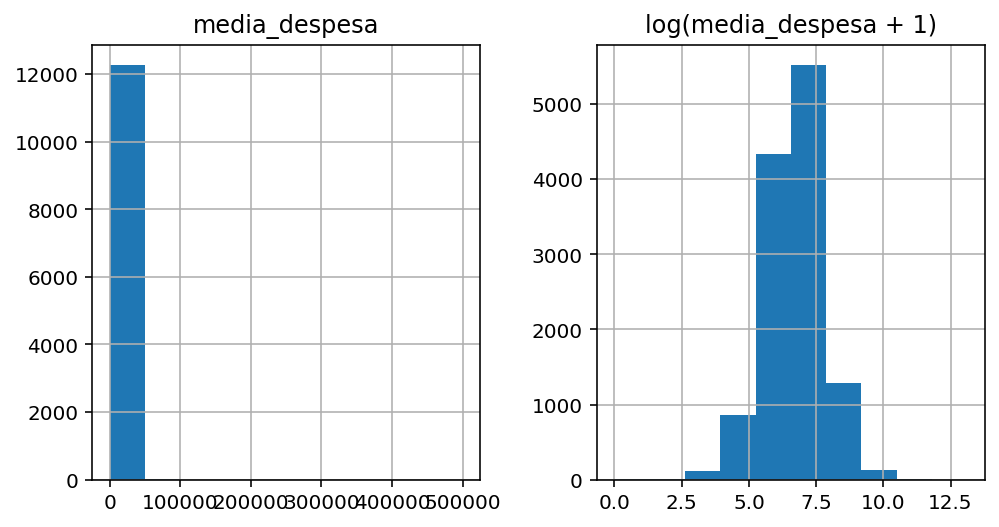

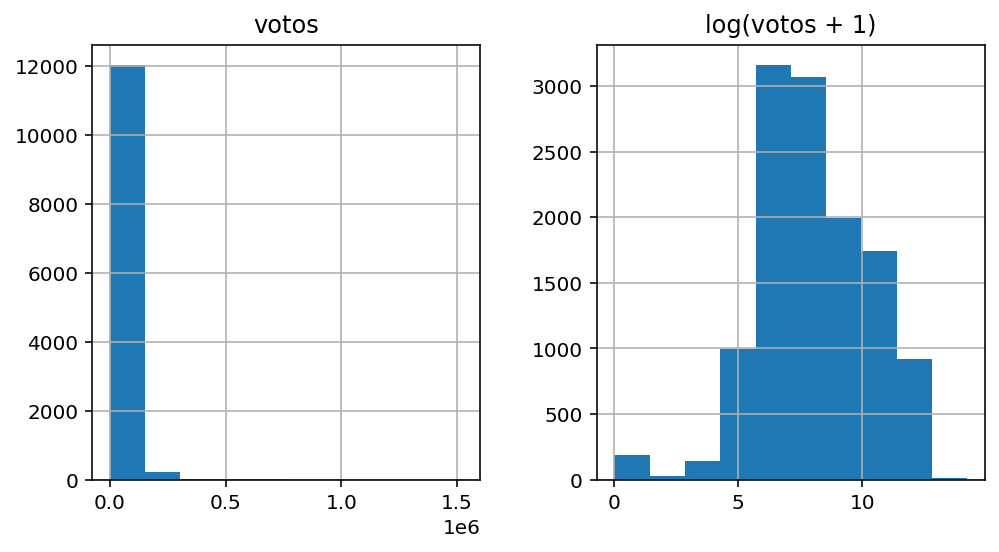

In [314]:
# renderizando a distribuição de cada uma das colunas (com e sem a aplicação do log)
matplotlib.rcParams['figure.figsize'] = (8.0, 4.0)
for feature in features_to_log:
  hist = pd.DataFrame({"{0}".format(feature):data[feature], "log({0} + 1)".format(feature):np.log1p(data[feature])})
  hist.hist()

É possível observar, visualmente, que TODAS as variáveis necessitam normalização, algumas inclusive ainda necessitam mesmo após a aplicação do log uma única vez, são elas: quantidade_doacoes, quantidade_doadores, quantidade_despesas, quantidade_fornecedores.

Aplicando o log uma segunda vez para essas variáveis, temos:

In [315]:
double_log = ["quantidade_doacoes", "quantidade_doadores", "quantidade_despesas", "quantidade_fornecedores"]

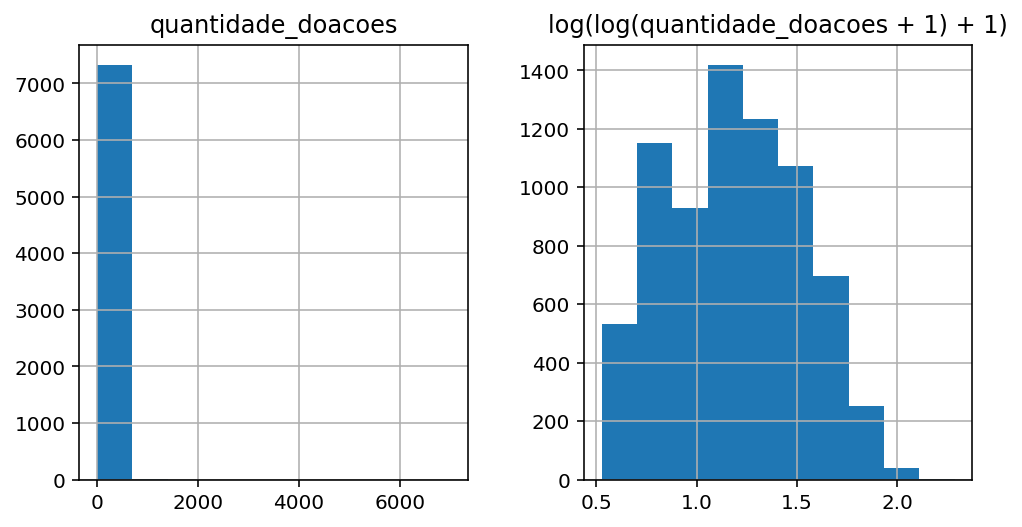

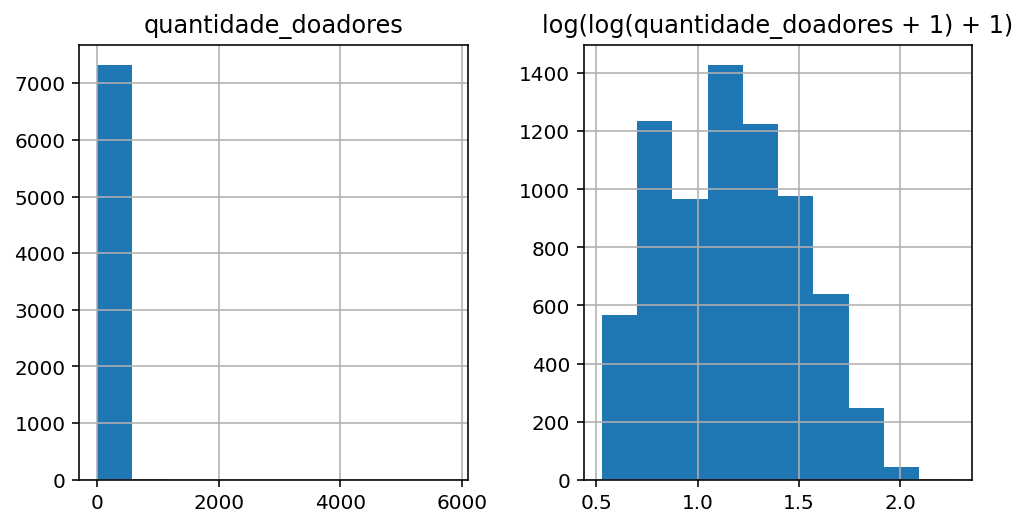

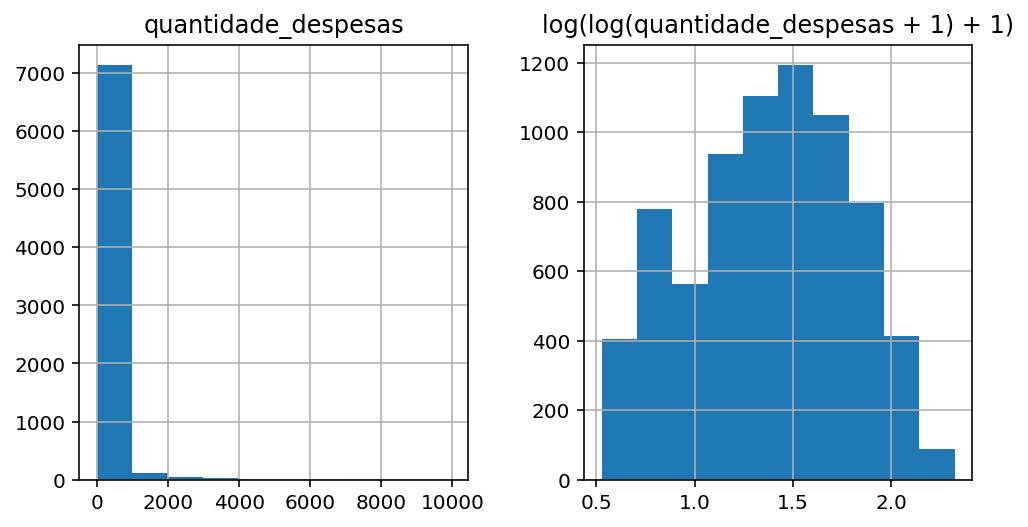

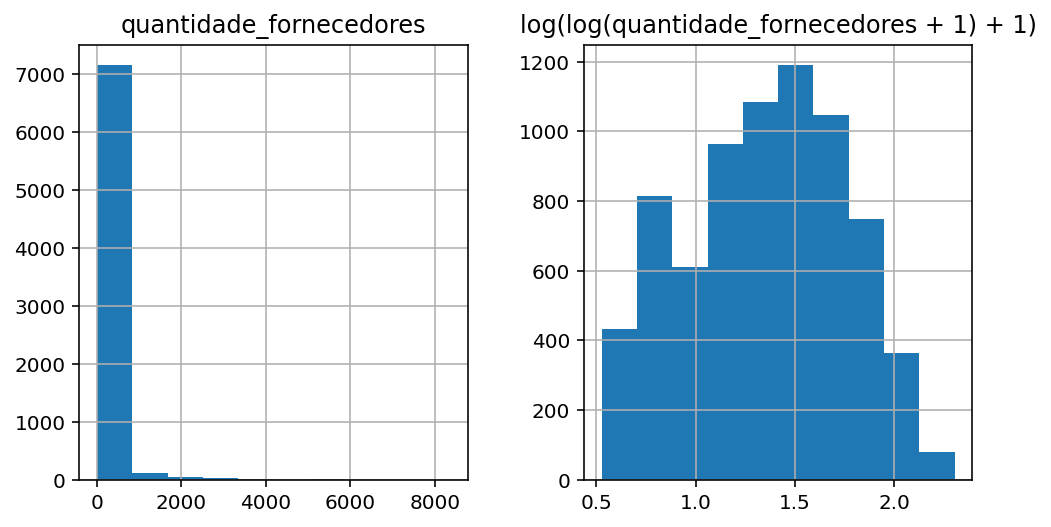

In [316]:
for feature in double_log:
  hist = pd.DataFrame({"{0}".format(feature):data[feature], "log(log({0} + 1) + 1)".format(feature):np.log1p(np.log1p(data[feature]))})
  hist.hist()

### Normalizando Variáveis

In [317]:
# Utilizando a métrica da função skew para verificar as colunas que necessitam normalização
skewed_feats = data[features_to_log].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

In [318]:
skewed_feats

Index(['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_proprios',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa', 'votos'],
      dtype='object')

In [319]:
data[skewed_feats] = np.log1p(data[skewed_feats])

In [320]:
# verificando se ainda existem variáveis necessitando normalização
still_skewed_feats = data[features_to_log].apply(lambda x: skew(x.dropna()))
still_skewed_feats = still_skewed_feats[still_skewed_feats > 0.75]
still_skewed_feats = still_skewed_feats.index

In [321]:
still_skewed_feats

Index([], dtype='object')

Como não existem mais variáveis além do limiar definido para o `skew` (0.75), não iremos tratar as demais variáveis.

In [322]:
data.head()

,ano,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,...,qtd_doadores,recursos de outros candidatos/comitês,recursos de pessoas físicas,recursos de pessoas jurídicas,recursos próprios,qtd_despesas,qtd_fornecedores,descricao_cargo,grau_instrucao,descricao_ocupacao
0,2006,AP,PT,1.945910,1.945910,9.717218,7.925760,NaN,9.105091,6300.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,RO,PT,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,1000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006,AP,PT,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,62220.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006,MS,PRONA,1.945910,1.945910,8.007074,6.216979,NaN,7.048386,1101.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006,RO,PT,3.891820,3.891820,NaN,NaN,NaN,10.837206,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tratando variáveis categóricas - gerando dummies

In [323]:
data = pd.get_dummies(data)

In [324]:
data.head()

,ano,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,...,descricao_ocupacao_TÉCNICO DE QUÍMICA,descricao_ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,descricao_ocupacao_TÉCNICO EM EDIFICAÇÕES,descricao_ocupacao_TÉCNICO EM INFORMÁTICA,descricao_ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"descricao_ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",descricao_ocupacao_VEREADOR,descricao_ocupacao_VETERINÁRIO,descricao_ocupacao_VIGILANTE,descricao_ocupacao_ZOOTECNISTA
0,2006,1.945910,1.945910,9.717218,7.925760,NaN,9.105091,6300.00,7.170888,2.708050,...,0,0,0,0,0,0,0,0,0,0
1,2006,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,1000.00,5.308268,3.218876,...,0,0,0,0,0,0,0,0,0,0
2,2006,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,62220.80,10.993748,4.820282,...,0,0,0,0,0,0,0,0,0,0
3,2006,1.945910,1.945910,8.007074,6.216979,NaN,7.048386,1101.12,6.621406,2.197225,...,0,0,0,0,0,0,0,0,0,0
4,2006,3.891820,3.891820,NaN,NaN,NaN,10.837206,NaN,11.141035,4.897840,...,0,0,0,0,0,0,0,0,0,0


## Tratando valores NA's

In [325]:
data = data.fillna(data.mean())

In [326]:
data.shape

(12266, 5426)

## Particionando Dataset

In [262]:
# definindo os datasets a partir do ano da votação (conforme sugerido)
# a coluna ano também foi removida

X_train = data[data.ano == 2006].drop(columns=['votos', 'ano'])
Y_train = data[data.ano == 2006]['votos']

X_validation = data[data.ano == 2010].drop(columns=['votos', 'ano'])
Y_validation = data[data.ano == 2010]['votos']

X_test = data[data.ano == 2014].drop(columns=['votos', 'ano'])
Y_test = data[data.ano == 2014]['votos']

## Treinando Modelos

In [263]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

def rmse_cv(model, X, Y, cv = 5):
    rmse = np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=cv))
    return(rmse)

def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))
    


### Ridge

In [93]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

cv_ridge = [rmse_cv(Ridge(alpha=alpha), X_train, Y_train).mean() for alpha in alphas]

Text(0, 0.5, 'rmse')

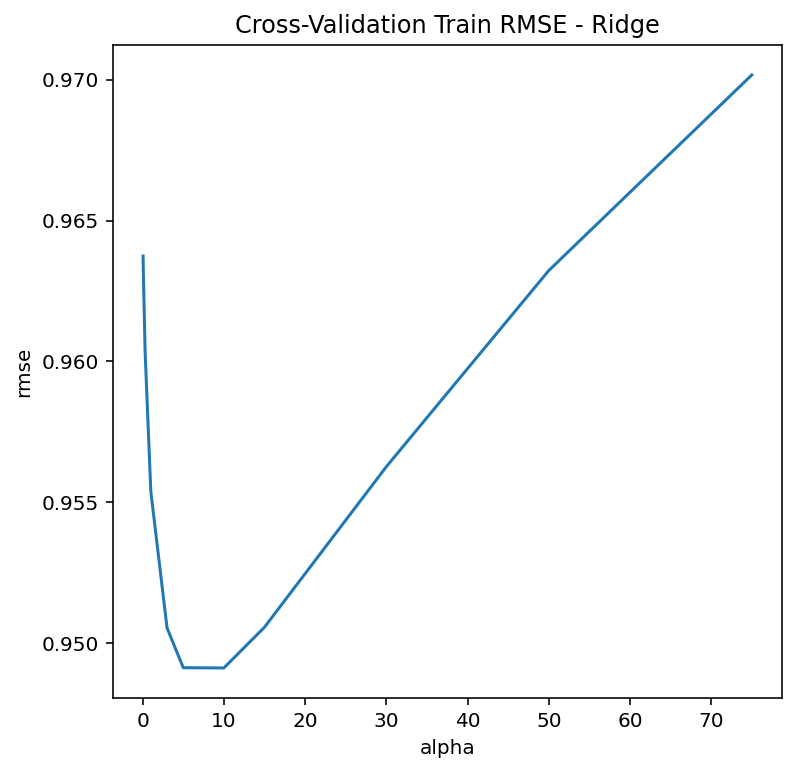

In [94]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Cross-Validation Train RMSE - Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [95]:
cv_ridge.min()

0.9491270156705982

In [98]:
model_ridge = RidgeCV(alphas = [10]).fit(X_train, Y_train)

Text(0.5, 1.0, 'Resíduos - Ridge')

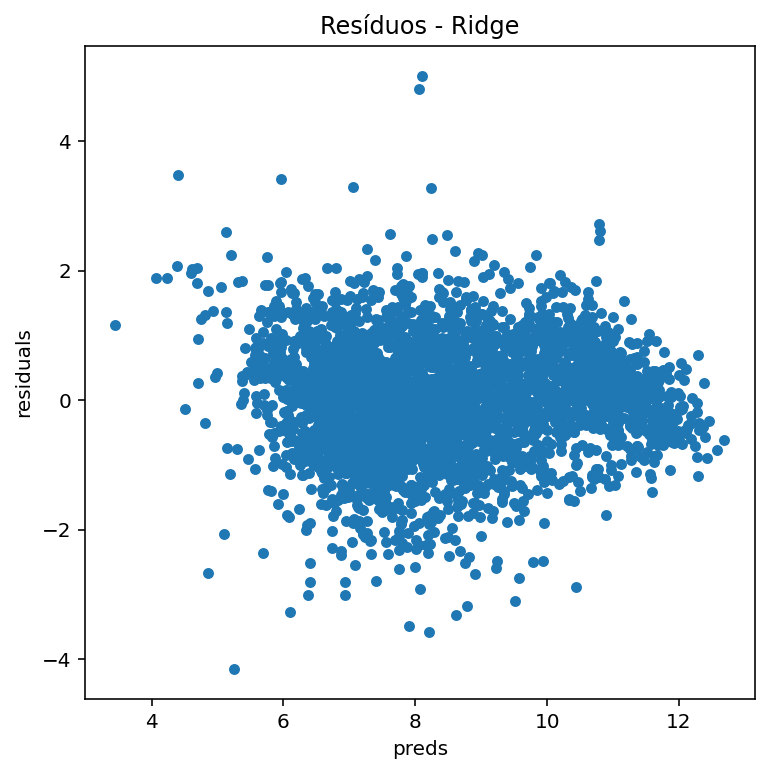

In [99]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true":Y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Resíduos - Ridge")

In [100]:
rmse(Y_validation, model_ridge.predict(X_validation))

1.08170601348069

Foi obtido um RMSE de **0.9491270156705982** para os dados de treino e de **1.08170601348069** para os de validação.

É possível observar no gráfico acima, o de resíduos, que há uma distribuição dispersa, indicando que o modelo está posivelmente adequado ao problema.

### Lasso

In [101]:
# model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.0005], max_iter=10000).fit(X_train, Y_train)
alphas = [0.000001, 0.00005, 0.0001, 0.0005, 0.001, 0.05, 0.1]
cv_lasso = [rmse_cv(Lasso(alpha=alpha, max_iter=20000), X_train, Y_train).mean() for alpha in alphas]

/home/mateus/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3406520409200766, tolerance: 0.9545757002954055
  model = cd_fast.enet_coordinate_descent(
/home/mateus/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2406243438174442, tolerance: 1.0118165558869001
  model = cd_fast.enet_coordinate_descent(
/home/mateus/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.263731075094256, tolerance: 1.015520661504851
  model = cd_fast.enet_coordinate_descent(


Text(0, 0.5, 'rmse')

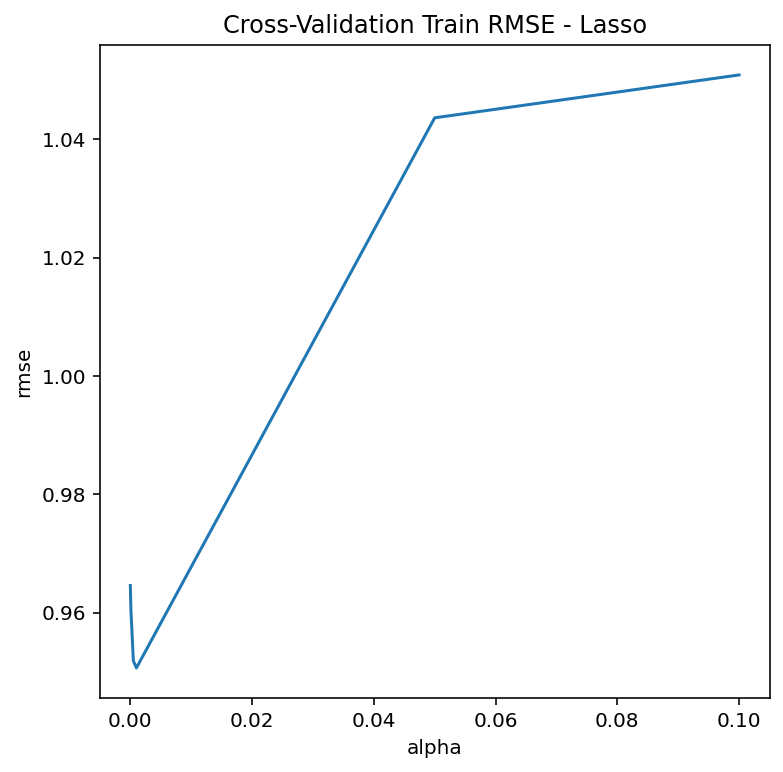

In [102]:
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Cross-Validation Train RMSE - Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [103]:
cv_lasso.min()

0.9506276342556133

In [104]:
cv_lasso

0.000001    0.964578
0.000050    0.962233
0.000100    0.960330
0.000500    0.951824
0.001000    0.950628
0.050000    1.043657
0.100000    1.050912
dtype: float64

In [105]:
model_lasso = LassoCV(alphas = [0.001], max_iter=20000).fit(X_train, Y_train)

In [106]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [107]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 101 variables and eliminated the other 159 variables


In [108]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

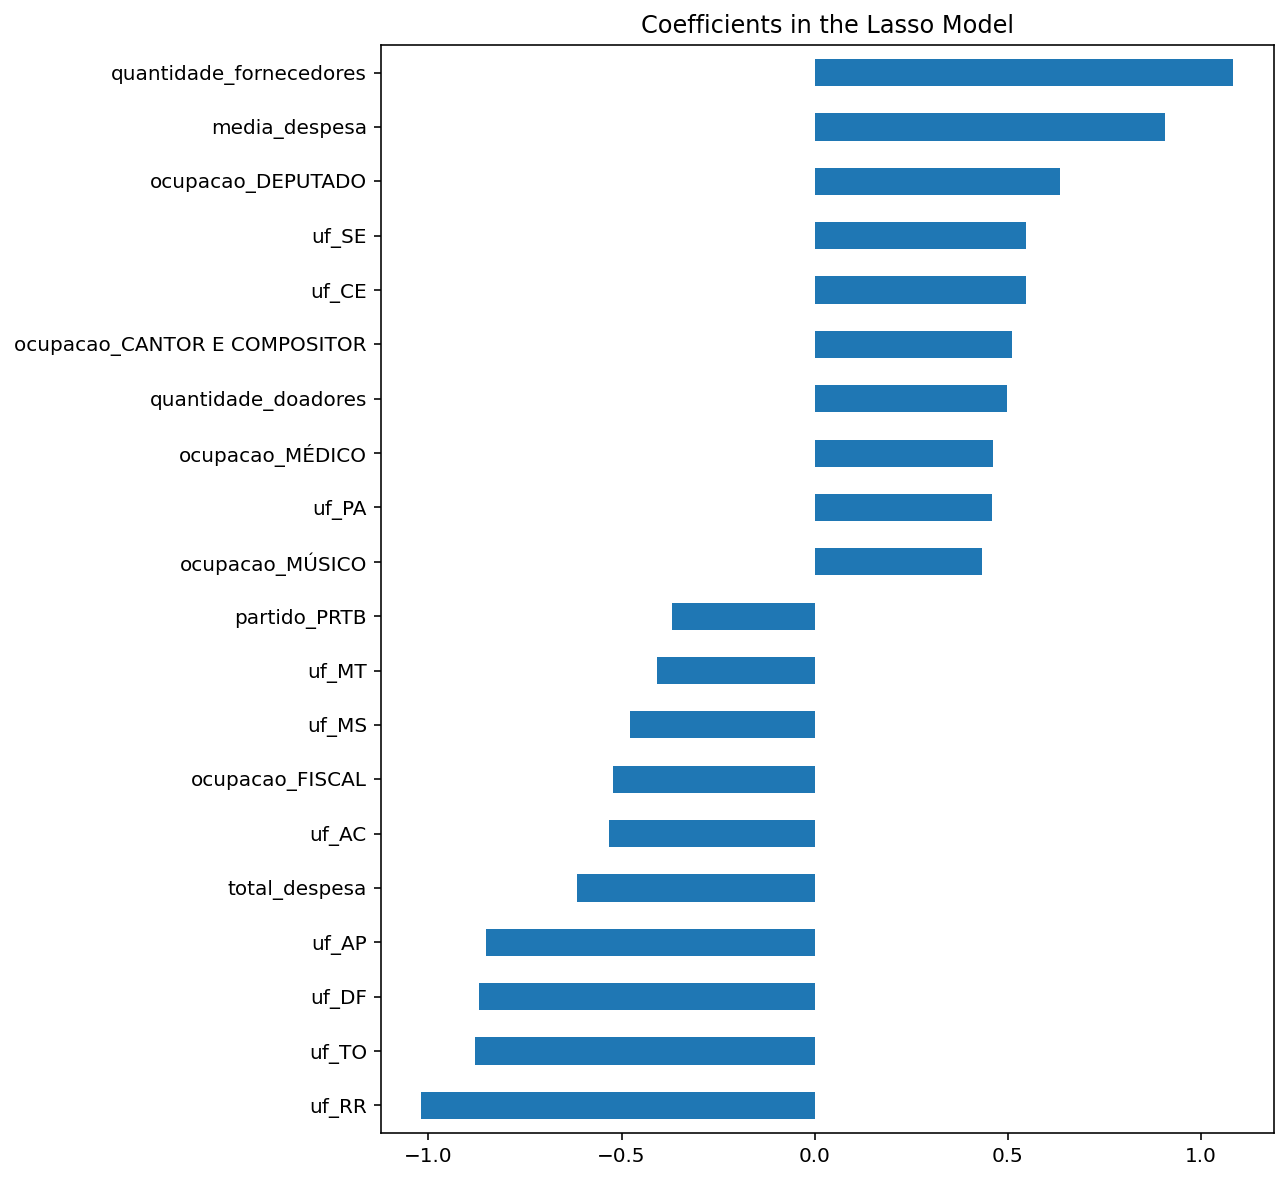

In [109]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Text(0.5, 1.0, 'Resíduos - Lasso')

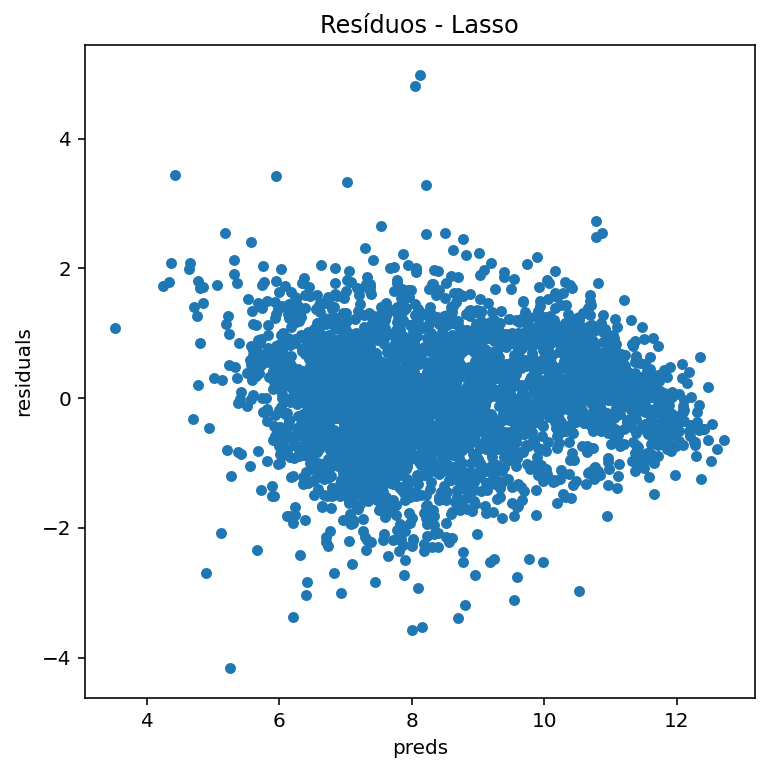

In [110]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":Y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Resíduos - Lasso")

In [111]:
rmse(Y_validation, model_lasso.predict(X_validation))

1.0826656205198513

Foi obtido um RMSE de **0.9506276342556133** para os dados de treino e de **1.0826656205198513** para os de validação.

É possível observar no gráfico acima, o de resíduos, que há uma distribuição dispersa, indicando que o modelo está posivelmente adequado ao problema.

### Regressão Linear

In [217]:
from sklearn.feature_selection import RFE

In [229]:
hyper_params = [{'n_features_to_select': list(range(2, 250, 10))}]
lm = LinearRegression()
lm.fit(X_train, Y_train)
rfe = RFE(lm)

In [230]:
grid_lr = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = 5, 
                        verbose = 1,
                        return_train_score=True)     

In [231]:
grid_lr.fit(X_train, Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 12, 22, 32, 42, 52, 62,
                                                   72, 82, 92, 102, 112, 122,
                                                   132, 142, 152, 162, 172, 182,
                                                   192, 202, 212, 222, 232,
                                                   242]}],
             return_train_score=True, scoring='r2', verbose=1)

In [235]:
print(grid_lr.best_params_)
print(grid_lr.best_estimator_)

{'n_features_to_select': 52}
RFE(estimator=LinearRegression(), n_features_to_select=52)


In [ ]:
pred_lr = grid_lr.predict(X_train)

In [ ]:
rmse_pred_lr = rmse(Y_train, pred_lr)

In [ ]:
rmse_pred_lr

In [236]:
pred_lr = grid_lr.predict(X_validation)
rmse_pred_lr = rmse(Y_validation, pred_lr)

In [239]:
rmse_pred_lr

719259485308.7551

Text(0.5, 1.0, 'Resíduos - Regressão Linear')

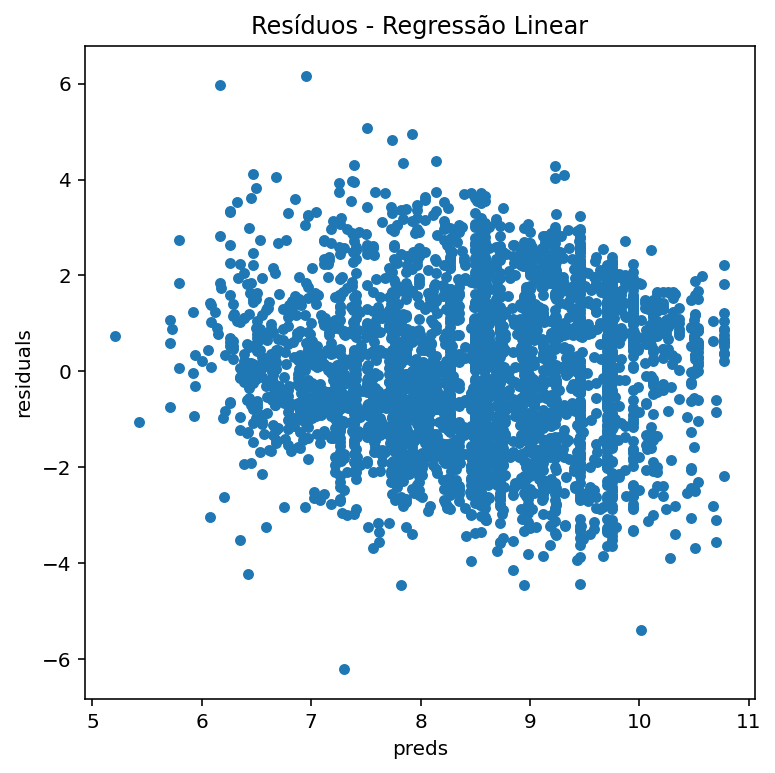

In [240]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":grid_lr.predict(X_train), "true":Y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Resíduos - Regressão Linear")

In [158]:
predicted_lr = model_lr.predict(X_validation)

In [162]:
rmse(Y_validation, predicted_lr)

7089.8797455165295

Foi obtido um RMSE de **-** para os dados de treino e de **7089.8797455165295** para os de validação. Valores bem mais altos do que os encontrados nos modelos com regualirazação.

É possível observar no gráfico acima, o de resíduos, que há uma distribuição dispersa, entretando com alguns traços horizontais, indicando que o modelo não se adequou tão bem ao problema.

### XGBoost

In [166]:
!pip install xgboost

     |████████████████████████████████| 255.9 MB 10.7 MB/s eta 0:00:01   |███████▊                        | 61.7 MB 6.3 MB/s eta 0:00:31     |██████████▊                     | 85.8 MB 4.5 MB/s eta 0:00:38     |██████████████▌                 | 115.5 MB 5.4 MB/s eta 0:00:27     |███████████████▍                | 122.9 MB 7.4 MB/s eta 0:00:18


In [167]:
import xgboost as xgb

In [198]:
from xgboost.sklearn import XGBRegressor

In [200]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

In [201]:
xgb_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[20:54:09] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:09] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:54:09] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:09] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any su

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [202]:
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=4,
             nthread=4, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, ...)


In [ ]:
pred_xgb = xgb_grid.predict(X_train)
rmse_pred_xgb = rmse(Y_train, pred_xgb)

In [ ]:
rmse_pred_xgb

Text(0.5, 1.0, 'Resíduos - XGBoost')

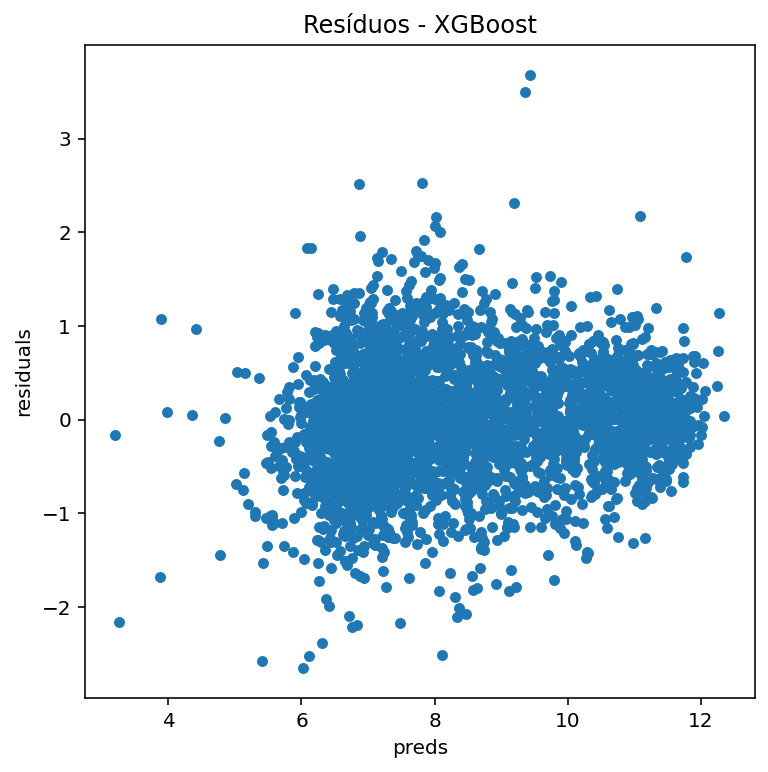

In [206]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":xgb_grid.predict(X_train), "true":Y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Resíduos - XGBoost")

In [204]:
pred_xgb = xgb_grid.predict(X_validation)
rmse_pred_xgb = rmse(Y_validation, pred_xgb)

In [205]:
rmse_pred_xgb

1.053559658905195

Foi obtido um RMSE de **-** para os dados de treino e de **1.053559658905195** para os de validação. 

É possível observar no gráfico acima, o de resíduos, que há uma distribuição dispersa, indicando que o modelo conseguiu se adequar de forma satisfatória ao problema.

### Random Forests

In [327]:
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
param_grid = { 
        "n_estimators"      : [10,20,30],
        "max_features"      : ["auto", "sqrt", "log2"],
        "min_samples_split" : [2,4,8],
        "bootstrap": [True, False],
        }
random_forest_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

In [328]:
random_forest_grid.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 30]})

In [334]:
print(random_forest_grid.best_params_)
print(random_forest_grid.best_estimator_)

{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 30}
RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=30)


In [335]:
pred_random_forest = random_forest_grid.predict(X_validation)

In [336]:
rmse_pred_random_forest = rmse(Y_validation, pred_random_forest)

In [337]:
rmse_pred_random_forest

0.002309955976837259

Text(0.5, 1.0, 'Resíduos - Random Forests')

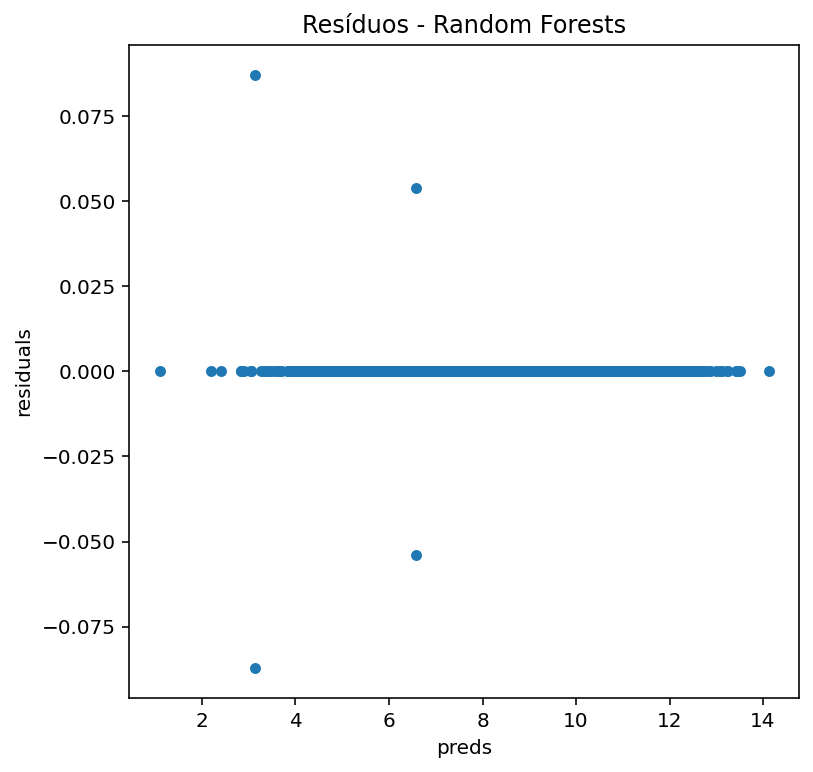

In [333]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":random_forest_grid.predict(X_train), "true":Y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Resíduos - Random Forests")

## Ajustado Dados

Para a obtenção das métricas definitivas dos modelos definidos acima, as partições de treino e validação serão combinadas.

In [339]:
X_train = pd.concat([X_train, X_validation])
Y_train = pd.concat([Y_train, Y_validation])

## Testando Modelos

### Regressão Ridge

In [265]:
model_ridge = RidgeCV(alphas = [10]).fit(X_train, Y_train)

In [270]:
definitive_rmse_ridge = rmse(Y_test, model_ridge.predict(X_test))

In [271]:
definitive_rmse_ridge

3.2949831406671697

### Regressão Lasso

In [272]:
model_lasso = LassoCV(alphas = [0.001], max_iter=20000).fit(X_train, Y_train)

In [273]:
definitive_rmse_lasso = rmse(Y_test, model_lasso.predict(X_test))

In [274]:
definitive_rmse_lasso

3.369390100674941

### Regressão Linear

In [347]:
hyper_params = [{'n_features_to_select': [52]}]
lm = LinearRegression()
lm.fit(X_train, Y_train)
rfe = RFE(lm)

In [348]:
definitive_grid_lr = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = 5, 
                        verbose = 1,
                        return_train_score=True)     

In [349]:
definitive_grid_lr.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
predicted_lr_definitive = definitive_grid_lr.predict(X_test)

In [ ]:
definitive_rmse_lr = rmse(Y_test, predicted_lr_definitive)

In [ ]:
definitive_rmse_lr

### XGBoost

In [284]:
definitive_xgb1 = XGBRegressor()
parameters = {'colsample_bytree': [0.7], 'learning_rate': [0.03], 'max_depth': [5], 'min_child_weight': [4], 'n_estimators': [500], 'nthread': [4], 'objective': ['reg:linear'], 'silent': [1], 'subsample': [0.7]}
definitive_xgb_grid = GridSearchCV(definitive_xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

definitive_xgb_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[22:34:05] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[22:34:05] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:34:05] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[22:34:05] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any suc

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [287]:
definitive_rmse_xgb = rmse(Y_test, definitive_xgb_grid.predict(X_test))

In [288]:
definitive_rmse_xgb

1.892648091869807

### Random Forests

In [338]:
# {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 30}
random_forest_model = RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=2, n_estimators=30)

In [340]:
random_forest_model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=30)

In [343]:
predictions_random_forest = random_forest_model.predict(X_test)

In [345]:
definitive_rmse_random_forests = rmse(Y_test, predictions_random_forest)

In [346]:
definitive_rmse_random_forests

2.0452675639195306

## Conclusão

Foram construídos X modelos, sendo eles:
- Regressão Ridge;
- Regressão Lasso;
- Regressão Linear;
- XGBoost;
- 